## 목표  
미세조정 학습에 대해 알아보고 처음부터 모델을 설계하는 것과 미세 조정 모델간의 차이에 대해 알아보자.


# Load Data

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import pandas as pd
from tqdm import tqdm

In [4]:
df = pd.read_csv('./datasets/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [5]:
df.shape

(9120, 272)

In [6]:
df['people'].unique()

array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8'], dtype=object)

In [7]:
df.isna().sum()

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64

In [8]:
df.columns

Index(['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std',
       'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var',
       ...
       'LL_ymag_std', 'LL_ymag_skew', 'LL_zmag_mean', 'LL_zmag_max',
       'LL_zmag_min', 'LL_zmag_var', 'LL_zmag_std', 'LL_zmag_skew', 'activity',
       'people'],
      dtype='object', length=272)

In [9]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

Text(0, 0.5, 'Count')

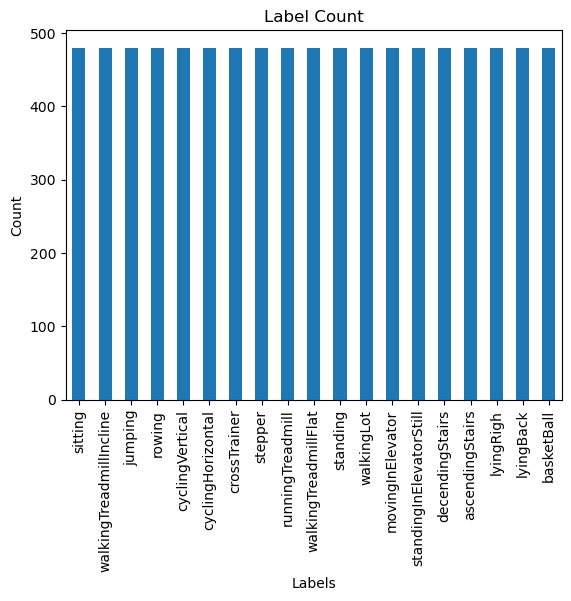

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 레이블별 갯수 확인
label_counts = df['activity'].value_counts()

# 바 그래프 그리기
label_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')

## RA, LA 데이터 분리

In [12]:
df_RA = df.filter(regex='RA_') # 오른팔
df_LA = df.filter(regex='LA_') # 왼팔 

In [13]:
df_RA.insert(3, 'activity', df['activity'])
df_LA.insert(3, 'activity', df['activity'])

In [14]:
df_RA.head()

,RA_xacc_mean,RA_xacc_max,RA_xacc_min,activity,RA_xacc_var,RA_xacc_std,RA_xacc_skew,RA_yacc_mean,RA_yacc_max,RA_yacc_min,...,RA_ymag_min,RA_ymag_var,RA_ymag_std,RA_ymag_skew,RA_zmag_mean,RA_zmag_max,RA_zmag_min,RA_zmag_var,RA_zmag_std,RA_zmag_skew
0,0.679134,0.75930,0.58542,sitting,0.001546,0.039324,-0.415694,5.713088,5.8483,5.5956,...,-0.57428,0.000012,0.003401,-0.052190,-0.211136,-0.18401,-0.24523,0.000044,0.006638,-1.153902
1,0.644964,0.73158,0.53064,sitting,0.001333,0.036508,0.410625,5.795154,5.9546,5.6687,...,-0.57398,0.000005,0.002216,0.222740,-0.206431,-0.18054,-0.23624,0.000032,0.005660,0.458427
2,0.608212,0.67737,0.53546,sitting,0.000637,0.025244,0.153302,5.833086,5.8918,5.7656,...,-0.57563,0.000004,0.001954,-0.221765,-0.205648,-0.18342,-0.22933,0.000024,0.004868,-0.984915
3,0.591138,0.71177,0.51524,sitting,0.001349,0.036731,0.525019,5.863846,5.9645,5.7556,...,-0.57858,0.000007,0.002688,0.075011,-0.203739,-0.17999,-0.22958,0.000026,0.005099,0.185634
4,0.558168,0.67190,0.50535,sitting,0.000626,0.025020,1.076782,5.884745,5.9401,5.8384,...,-0.57996,0.000005,0.002278,-0.219440,-0.203684,-0.17904,-0.22924,0.000027,0.005175,-0.820907


In [15]:
df_LA.head()

,LA_xacc_mean,LA_xacc_max,LA_xacc_min,activity,LA_xacc_var,LA_xacc_std,LA_xacc_skew,LA_yacc_mean,LA_yacc_max,LA_yacc_min,...,LA_ymag_min,LA_ymag_var,LA_ymag_std,LA_ymag_skew,LA_zmag_mean,LA_zmag_max,LA_zmag_min,LA_zmag_var,LA_zmag_std,LA_zmag_skew
0,3.403317,3.4875,3.2682,sitting,0.001583,0.039790,-0.744647,-8.375713,-8.2927,-8.4821,...,0.33748,0.000003,0.001810,-0.215069,0.072273,0.076374,0.067940,0.000004,0.001910,-0.166015
1,3.427302,3.6630,3.3168,sitting,0.004305,0.065614,1.000107,-8.397591,-8.3118,-8.5017,...,0.33000,0.000017,0.004159,-0.611251,0.074557,0.085184,0.068169,0.000022,0.004643,0.717286
2,3.400870,3.5168,3.3315,sitting,0.001007,0.031732,0.978319,-8.439138,-8.3599,-8.5204,...,0.33307,0.000002,0.001316,-0.506255,0.075852,0.083227,0.072507,0.000004,0.002106,1.043919
3,3.391002,3.5311,3.2608,sitting,0.001792,0.042328,0.117935,-8.441421,-8.3207,-8.5446,...,0.33431,0.000002,0.001395,0.155251,0.074878,0.080059,0.069942,0.000006,0.002414,0.242524
4,3.359974,3.4434,3.3069,sitting,0.000633,0.025160,1.051627,-8.454854,-8.3202,-8.5561,...,0.33631,0.000001,0.001005,-0.299017,0.073398,0.077461,0.070175,0.000002,0.001482,0.606258


In [16]:
df_LA['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [17]:
df_RA['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_RA['activity'] = label_encoder.fit_transform(df_RA['activity'])

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()
# 'label' 컬럼을 숫자로 변환
df_LA['activity'] = label_encoder.fit_transform(df_LA['activity'])

C:\Users\user\AppData\Local\Temp\ipykernel_3464\3441972880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RA['activity'] = label_encoder.fit_transform(df_RA['activity'])
C:\Users\user\AppData\Local\Temp\ipykernel_3464\3441972880.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LA['activity'] = label_encoder.fit_transform(df_LA['activity'])


In [19]:
df_LA['activity'].value_counts()

activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64

In [20]:
df_RA['activity'].value_counts()

activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64

## Train, Test 분리 - LA, RA

In [22]:
# Right Arm
df_RA_Y=df_RA['activity']

In [23]:
df_RA_X=df_RA.drop('activity',axis=1)
df_RA_X.head()

,RA_xacc_mean,RA_xacc_max,RA_xacc_min,RA_xacc_var,RA_xacc_std,RA_xacc_skew,RA_yacc_mean,RA_yacc_max,RA_yacc_min,RA_yacc_var,...,RA_ymag_min,RA_ymag_var,RA_ymag_std,RA_ymag_skew,RA_zmag_mean,RA_zmag_max,RA_zmag_min,RA_zmag_var,RA_zmag_std,RA_zmag_skew
0,0.679134,0.75930,0.58542,0.001546,0.039324,-0.415694,5.713088,5.8483,5.5956,0.003779,...,-0.57428,0.000012,0.003401,-0.052190,-0.211136,-0.18401,-0.24523,0.000044,0.006638,-1.153902
1,0.644964,0.73158,0.53064,0.001333,0.036508,0.410625,5.795154,5.9546,5.6687,0.001132,...,-0.57398,0.000005,0.002216,0.222740,-0.206431,-0.18054,-0.23624,0.000032,0.005660,0.458427
2,0.608212,0.67737,0.53546,0.000637,0.025244,0.153302,5.833086,5.8918,5.7656,0.000488,...,-0.57563,0.000004,0.001954,-0.221765,-0.205648,-0.18342,-0.22933,0.000024,0.004868,-0.984915
3,0.591138,0.71177,0.51524,0.001349,0.036731,0.525019,5.863846,5.9645,5.7556,0.001423,...,-0.57858,0.000007,0.002688,0.075011,-0.203739,-0.17999,-0.22958,0.000026,0.005099,0.185634
4,0.558168,0.67190,0.50535,0.000626,0.025020,1.076782,5.884745,5.9401,5.8384,0.000471,...,-0.57996,0.000005,0.002278,-0.219440,-0.203684,-0.17904,-0.22924,0.000027,0.005175,-0.820907


In [24]:
from sklearn.model_selection import train_test_split

X_train_RA, X_test_RA, y_train_RA, y_test_RA = train_test_split(df_RA_X, 
                                                    df_RA_Y,
                                                    test_size = 0.25, 
                                                    random_state = 21)

In [25]:
# Left Arm
df_LA_Y = df_LA['activity']
df_LA_Y.head()

0    12
1    12
2    12
3    12
4    12
Name: activity, dtype: int32

In [26]:
df_LA_X=df_LA.drop('activity',axis=1)
df_LA_X.head()

,LA_xacc_mean,LA_xacc_max,LA_xacc_min,LA_xacc_var,LA_xacc_std,LA_xacc_skew,LA_yacc_mean,LA_yacc_max,LA_yacc_min,LA_yacc_var,...,LA_ymag_min,LA_ymag_var,LA_ymag_std,LA_ymag_skew,LA_zmag_mean,LA_zmag_max,LA_zmag_min,LA_zmag_var,LA_zmag_std,LA_zmag_skew
0,3.403317,3.4875,3.2682,0.001583,0.039790,-0.744647,-8.375713,-8.2927,-8.4821,0.001178,...,0.33748,0.000003,0.001810,-0.215069,0.072273,0.076374,0.067940,0.000004,0.001910,-0.166015
1,3.427302,3.6630,3.3168,0.004305,0.065614,1.000107,-8.397591,-8.3118,-8.5017,0.001098,...,0.33000,0.000017,0.004159,-0.611251,0.074557,0.085184,0.068169,0.000022,0.004643,0.717286
2,3.400870,3.5168,3.3315,0.001007,0.031732,0.978319,-8.439138,-8.3599,-8.5204,0.000684,...,0.33307,0.000002,0.001316,-0.506255,0.075852,0.083227,0.072507,0.000004,0.002106,1.043919
3,3.391002,3.5311,3.2608,0.001792,0.042328,0.117935,-8.441421,-8.3207,-8.5446,0.001862,...,0.33431,0.000002,0.001395,0.155251,0.074878,0.080059,0.069942,0.000006,0.002414,0.242524
4,3.359974,3.4434,3.3069,0.000633,0.025160,1.051627,-8.454854,-8.3202,-8.5561,0.001061,...,0.33631,0.000001,0.001005,-0.299017,0.073398,0.077461,0.070175,0.000002,0.001482,0.606258


In [27]:
from sklearn.model_selection import train_test_split

X_train_LA, X_test_LA, y_train_LA, y_test_LA = train_test_split(df_LA_X, 
                                                    df_LA_Y,
                                                    test_size = 0.25, 
                                                    random_state = 21)

In [28]:
X_train_RA.shape, X_test_RA.shape, y_train_RA.shape, y_test_RA.shape

((6840, 54), (2280, 54), (6840,), (2280,))

In [29]:
X_train_LA.shape, X_test_LA.shape, y_train_LA.shape, y_test_LA.shape

((6840, 54), (2280, 54), (6840,), (2280,))

## 순환 데이터 전환 & One-Hot Encode Target Variable

Split Seuqence -> 순환형 데이터

In [32]:
from collections import Counter
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [33]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array_RA = np.array(y_train_RA)
train_set_RA = np.c_[X_train_RA, y_train_array_RA]

y_test_array_RA = np.array(y_test_RA)
test_set_RA = np.c_[X_test_RA, y_test_array_RA]

In [34]:
n_step = 3 

X_train_seq_RA, y_train_seq_RA = split_sequences(train_set_RA, n_step)
print(X_train_seq_RA.shape, y_train_seq_RA.shape)

X_test_seq_RA, y_test_seq_RA = split_sequences(test_set_RA, n_step)
print(X_test_seq_RA.shape, y_test_seq_RA.shape)

(6838, 3, 54) (6838,)
(2278, 3, 54) (2278,)


In [35]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array_LA = np.array(y_train_LA)
train_set_LA = np.c_[X_train_LA, y_train_array_LA]

y_test_array_LA = np.array(y_test_LA)
test_set_LA = np.c_[X_test_LA, y_test_array_LA]

In [36]:
n_step = 3 

X_train_seq_LA, y_train_seq_LA = split_sequences(train_set_LA, n_step)
print(X_train_seq_LA.shape, y_train_seq_LA.shape)

X_test_seq_LA, y_test_seq_LA = split_sequences(test_set_LA, n_step)
print(X_test_seq_LA.shape, y_test_seq_LA.shape)

(6838, 3, 54) (6838,)
(2278, 3, 54) (2278,)


One-Hot Encode target variable

In [38]:
from keras.utils import to_categorical

# Convert output variables to categorical for CNN
y_train_seq_RA = to_categorical(y_train_seq_RA)
print(y_train_seq_RA.shape)

y_test_seq_RA = to_categorical(y_test_seq_RA)
print(y_test_seq_RA.shape)

(6838, 19)
(2278, 19)


In [39]:
# Convert output variables to categorical for CNN
y_train_seq_LA = to_categorical(y_train_seq_LA)
print(y_train_seq_LA.shape)

y_test_seq_LA = to_categorical(y_test_seq_LA)
print(y_test_seq_LA.shape)

(6838, 19)
(2278, 19)


In [40]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train_seq_RA.shape[1], X_train_seq_RA.shape[2], y_train_seq_RA.shape[1]
print(n_timesteps, n_features, n_outputs)

3 54 19


# Model Structure

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D

## (1) 처음부터 모델 설계

In [44]:
# Build CNN model using keras. For model building suggestions, referenced:
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model = Sequential()
model.add(LSTM(units=128, input_shape = (n_timesteps,n_features)))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(X_train_seq_RA, y_train_seq_RA, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.2027 - loss: 2.5392 - val_accuracy: 0.5468 - val_loss: 1.4022
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6217 - loss: 1.2014 - val_accuracy: 0.7149 - val_loss: 0.9618
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7587 - loss: 0.7988 - val_accuracy: 0.7909 - val_loss: 0.7638
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8159 - loss: 0.6327 - val_accuracy: 0.8158 - val_loss: 0.7123
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8505 - loss: 0.5066 - val_accuracy: 0.8099 - val_loss: 0.6868
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8804 - loss: 0.3983 - val_accuracy: 0.8582 - val_loss: 0.6247
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9023 - loss: 0.3300 - val_accuracy: 0.8494 - val_loss: 0.5721
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9295 - loss: 0.2606 - val_accu

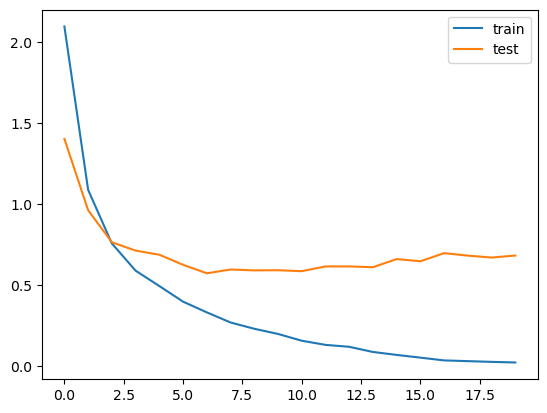

In [47]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

In [48]:
model.evaluate(X_train_seq_RA, y_train_seq_RA)

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9988 - loss: 0.0192


[0.08224182575941086, 0.9862532615661621]

In [49]:
model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8684 - loss: 0.6587


[0.6595136523246765, 0.866110622882843]

Confusion matrix

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Confusion Matrix


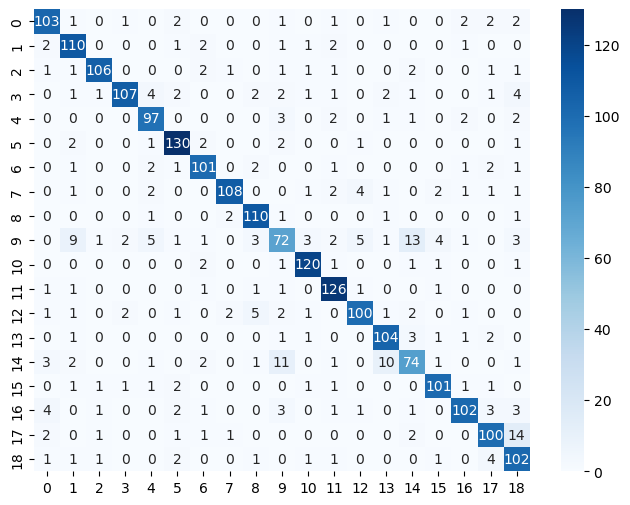

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq_RA, axis=1)
Y_pred = np.argmax(model.predict(X_test_seq_RA),axis=1)

print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()

In [52]:
base_loss,base_accuracy=model.evaluate(X_test_seq_RA, y_test_seq_RA)

model_file='./datasets/RA_Model.keras'
  
tf.keras.models.save_model(model, model_file, include_optimizer=False)
print('model saved at ', model_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8684 - loss: 0.6587
model saved at  ./datasets/RA_Model.keras
Accuracy >86.611062
Base Loss >0.66


In [53]:
# Build CNN model using keras. For model building suggestions, referenced:
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model2 = Sequential()
model2.add(LSTM(units=128, input_shape = (n_timesteps,n_features)))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(n_outputs, activation='softmax'))
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history2 = model2.fit(X_train_seq_LA, y_train_seq_LA, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.2171 - loss: 2.5190 - val_accuracy: 0.5439 - val_loss: 1.2880
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6509 - loss: 1.0804 - val_accuracy: 0.6988 - val_loss: 0.9163
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7725 - loss: 0.7606 - val_accuracy: 0.7880 - val_loss: 0.7217
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8487 - loss: 0.5322 - val_accuracy: 0.8246 - val_loss: 0.6342
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8753 - loss: 0.4323 - val_accuracy: 0.8392 - val_loss: 0.5661
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8947 - loss: 0.3561 - val_accuracy: 0.8596 - val_loss: 0.5025
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9207 - loss: 0.2819 - val_accuracy: 0.8611 - val_loss: 0.4965
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9410 - loss: 0.2078 - val_acc

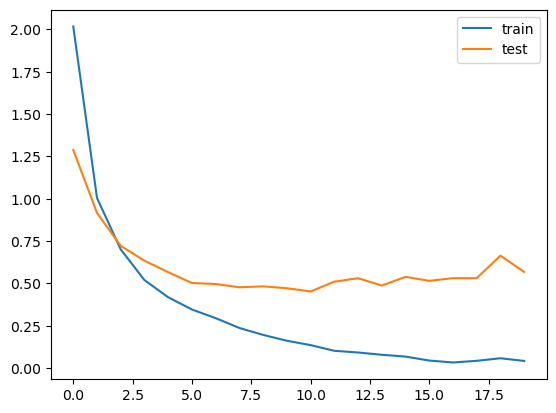

In [56]:
plt.plot(history2.history["loss"], label = "train")
plt.plot(history2.history["val_loss"], label = "test")
plt.legend()

In [57]:
model2.evaluate(X_train_seq_LA, y_train_seq_LA)

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9920 - loss: 0.0330


[0.08200221508741379, 0.9814273118972778]

In [58]:
model2.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8807 - loss: 0.5767


[0.5754761695861816, 0.8845478296279907]

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Confusion Matrix


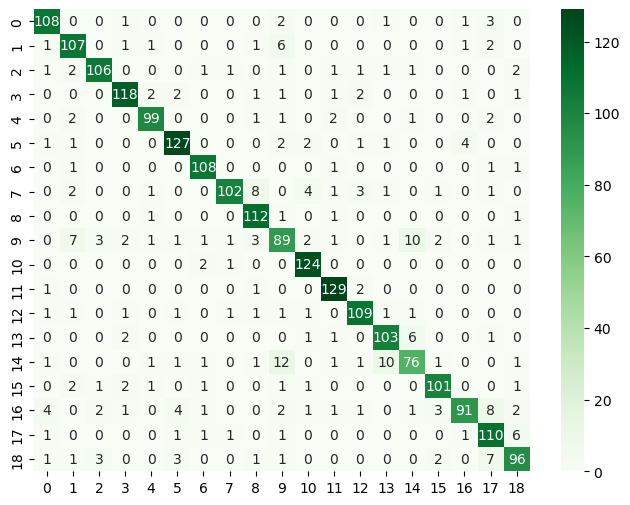

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq_LA, axis=1)
Y_pred = np.argmax(model2.predict(X_test_seq_LA),axis=1)

print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

# 그래프 표시
plt.show()

In [60]:
base_loss,base_accuracy=model2.evaluate(X_test_seq_LA, y_test_seq_LA)

model_file2='./datasets/LA_Model.keras'
  
tf.keras.models.save_model(model2, model_file2, include_optimizer=False)
print('model saved at ', model_file2)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8807 - loss: 0.5767
model saved at  ./datasets/LA_Model.keras
Accuracy >88.454783
Base Loss >0.58


학습시킨 LA 모델은 model_file 위치에, RA 모델 model_file2 위치에 저장해놓았다.  
바로 아래에서 로드하여 전이학습 및 미세조정에 사용할 것이다.

## (2) 전이 학습 및 미세 조정
### Load LA Model and Evaluate

In [63]:
# Base 모델을 로드 (LA_Model.keras)
from tensorflow.keras.models import load_model

base_model = load_model(model_file2)

In [64]:
base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8807 - loss: 0.5767


[0.5754761695861816, 0.8845478296279907]

In [65]:
base_model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2174 - loss: 5.9441


[5.7742390632629395, 0.22914837300777435]

로드한 LA 모델을 LA 데이터로 평가하면 88%의 정확도를 보이며, RA 데이터로 평가하면 22%의 정확도로 현저히 낮아짐을 보인다.

In [67]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  3


### 미세조정

저장된 basemodel에 층을 추가하여 미세조정해볼 것이다.   
이를 위해선 저장된 모델의 Output layer를 제외한 후 층을 쌓아야 한다.  


In [70]:
# 기존 모델 구조
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Output layer POP
base_model.pop()
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,208 (430.50 KB)

 Trainable params: 110,208 (430.50 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# 기존 모델의 층을 동결 (학습되지 않도록 설정)
base_model.trainable = False

# 새로운 모델을 정의
new_model = Sequential()

# 기존 모델을 추가
new_model.add(base_model)

# 새로운 완전연결층 추가
new_model.add(layers.Dense(64, activation='relu'))  # 기존 출력층 앞의 레이어 대신 추가

# 최종 출력층 추가 (예: 10개의 클래스)
new_model.add(layers.Dense(19, activation='softmax'))

new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# 모델 요약 출력
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 128)                 │         110,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,208 (430.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 110,208 (430.50 KB)

## Load RA Model & Evaluate

In [74]:
# Base 모델을 로드 (LA_Model.keras)
from tensorflow.keras.models import load_model

base_model = load_model(model_file) # 동결시킬 base model

In [75]:
base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8684 - loss: 0.6587


[0.6595136523246765, 0.866110622882843]

In [76]:
base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2608 - loss: 7.2114


[7.149883270263672, 0.25417032837867737]

LA 모델과 마찬가지로 RA 모델 또한 RA 데이터에 대해선 87%로 비교적 높은 정확도를, LA 데이터에 대해선 23%롤 낮은 정확도를 보인다.

#### 미세조정

### 미세조정과 처음부터 모델을 만들어서 학습한 것과의 차이

 앞서 우리는 미세 조정 학습을 위해, 학습된 모델을 로드해오고 모델의 output layer를 제거 후 층을 쌓았다. 학습된 모델의 가중치는 변화면 안되기 때문에 trainable=False를 통해 동결시켰다. 여기서 미세 조정의 이점을 파악할 수 있다. (학습을 통해 로드된 모델의 가중치가 변하면 로드해오는 의미가 없다.)
1. **학습 시간 단축**  
    이미 학습된 일반적인 특성을 재학습하지 않아도 되어 학습 속도가 크게 향상된다.
1. **효율적인 학습 시작점**  
   처음부터 모델을 설계하고, 학습을 시키면 알다시피 초기 가중치는 랜덤하게 설정되고 반복된 학습을 통해 오차를 최소화 하는 가중치를 찾는다. 미세조정 방식은 이미 잘 학습된 모델을 로드하고 동결시킴으로써, 위 과정을 생략한다. 이로써 기존과 유사한 도메인의 데이터일 경우 새로운 데이터 셋에 특화된 작은 조정만을 요구하므로 효율적이다. 다른 도메인일 경우에도 미세 조정을 통해 성능을 크게 개선할 수 있다는 이점이 생긴다.
   
